<a href="https://colab.research.google.com/github/harjotsinghparmar/Google-Colab-Deep-Learning/blob/master/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition 

Named entity recognition is the method in machine learning, specifically in natural language processing that used to tag words in a given sentence with the respective categories such as person name, identity, medical codes etc. 

I have been meaning to try it out myself using the bidirectional LSTM conditional random fields


In [0]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite 

Operation cancelled by user


In [0]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:

#Import all the modules
# for machine learning
import tensorflow as tf
import keras

#for data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
##import data 
! wget -cp http://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio
data = pd.read_csv('/content/groups.csail.mit.edu/sls/downloads/movie/engtrain.bio',delimiter="\t", names = ['Tag','Word'],skip_blank_lines=False)

#tag each sentence
data['sentence_no'] = 0
import numpy as np
ds = np.asarray(data)
#Run a loop through the numpy array and assign sentence number
i = 0 
for row in ds:
  if type(row[0])==float:
    i=i+1
    row[2]=None
  else:
    row[2]=i

In [0]:
# Convert back to dataframe and add column names 

data = pd.DataFrame(ds)
data.columns = ['Tag',"Word","Sentence #"]



In [0]:
## Generate dataset summary


print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=20) 

Number of sentences:  9775
Number of words in the dataset:  6711
Tags: [nan, 'I-YEAR', 'B-PLOT', 'I-REVIEW', 'B-TRAILER', 'B-GENRE', 'B-SONG', 'I-RATINGS_AVERAGE', 'B-DIRECTOR', 'I-DIRECTOR', 'B-REVIEW', 'I-SONG', 'I-TITLE', 'O', 'B-YEAR', 'B-RATINGS_AVERAGE', 'I-RATING', 'B-RATING', 'I-PLOT', 'I-CHARACTER', 'I-GENRE', 'B-TITLE', 'B-CHARACTER', 'B-ACTOR', 'I-TRAILER', 'I-ACTOR']
Number of Labels:  26
What the dataset looks like:


,Tag,Word,Sentence #
0,O,what,0
1,O,movies,0
2,O,star,0
3,B-ACTOR,bruce,0
4,I-ACTOR,willis,0
5,NaN,NaN,None
6,O,show,1
7,O,me,1
8,O,films,1
9,O,with,1


In [0]:
## Define aggregate lambda function 
agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]

In [0]:
sentences = data.groupby('Sentence #').apply(agg_func)

[('what', 'O'),
 ('movies', 'O'),
 ('star', 'O'),
 ('bruce', 'B-ACTOR'),
 ('willis', 'I-ACTOR')]

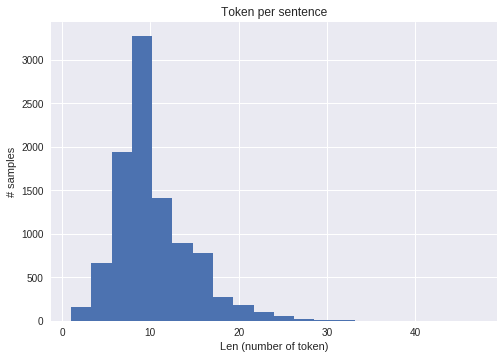

In [0]:
# Get all the sentences


# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=20)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [0]:
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 5  # Number of passes through entire dataset
MAX_LEN = 75  # Max length of review (in words)
EMBEDDING = 40  # Dimension of word embedding vector





# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["bruce"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["I-ACTOR"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 5294
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 26
Raw Sample:  what movies star bruce willis
Raw Label:  O O O B-ACTOR I-ACTOR
After processing, sample: [6055 6639 1302 5294   19    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [0]:
## Define the keras model 

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 40)            268520    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 27)            2160      
Total params: 312,130
Trainable params: 312,130
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=30,
                    validation_split=0.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 7917 samples, validate on 880 samples
Epoch 1/30
 - 13s - loss: 28.9480 - crf_viterbi_accuracy: 0.3374 - val_loss: 28.8543 - val_crf_viterbi_accuracy: 0.6198
Epoch 2/30
 - 10s - loss: 27.9975 - crf_viterbi_accuracy: 0.6127 - val_loss: 28.5205 - val_crf_viterbi_accuracy: 0.6198
Epoch 3/30
 - 10s - loss: 27.7732 - crf_viterbi_accuracy: 0.6128 - val_loss: 28.3722 - val_crf_viterbi_accuracy: 0.6198
Epoch 4/30
 - 10s - loss: 27.6243 - crf_viterbi_accuracy: 0.6128 - val_loss: 28.2305 - val_crf_viterbi_accuracy: 0.6206
Epoch 5/30
 - 10s - loss: 27.4670 - crf_viterbi_accuracy: 0.6187 - val_loss: 28.0769 - val_crf_viterbi_accuracy: 0.6327
Epoch 6/30
 - 10s - loss: 27.3206 - crf_viterbi_accuracy: 0.6393 - val_loss: 27.9726 - val_crf_viterbi_accuracy: 0.6533
Epoch 7/30
 - 10s - loss: 27.2308 - crf_viterbi_accuracy: 0.6721 - val_loss: 27.9127 - val_crf_viterbi_accuracy: 0.6886
Epoch 8/30
 - 10s - loss: 27.1627 - crf_viterbi_accuracy: 0.7004 

In [0]:
# Eval
pred_cat = model.predict(X_tr)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_tr, -1)

from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

          B-ACTOR       0.96      0.95      0.95      2917
      B-CHARACTER       0.61      0.54      0.57       339
       B-DIRECTOR       0.94      0.95      0.95      1551
          B-GENRE       0.94      0.97      0.95      3911
           B-PLOT       0.80      0.76      0.78      1734
         B-RATING       0.97      0.97      0.97      1812
B-RATINGS_AVERAGE       0.87      0.77      0.82      1696
         B-REVIEW       0.00      0.00      0.00       200
           B-SONG       0.91      0.14      0.25       217
          B-TITLE       0.88      0.88      0.88      2119
        B-TRAILER       0.84      0.69      0.76       100
           B-YEAR       0.96      0.95      0.96      2578
          I-ACTOR       0.96      0.94      0.95      3146
      I-CHARACTER       0.70      0.49      0.57       306
       I-DIRECTOR       0.95      0.95      0.95      1670
          I-GENRE       0.95      0.78      0.85       

In [0]:
i = np.random.randint(0,X_tr.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_tr[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_tr[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_tr.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_tr[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1874 of 8797 (Test Set)
Word           ||True ||Pred
please         : O     O
list           : O     O
any            : O     O
musical        : B-GENRE B-GENRE
movies         : O     O
from           : O     O
the            : O     O
1960           : B-YEAR B-YEAR
s              : I-YEAR I-YEAR
with           : O     O
ileana         : B-ACTOR B-ACTOR
douglas        : I-ACTOR I-ACTOR
in             : O     O
them           : O     O
